# **Data science lab**
### Laboratory number: 2

This laboratory is concerned of data preparation process, we will cope task using tabular and textual input data; so here we will cover how to handle those anomalies, as well.


Here in this lab we need the library *matplotlib*

Below a snippet of code on how to plot a gaussian distribution as an histogram (recall an histogram represents distribution of numerical data)

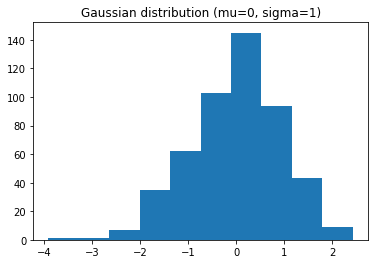

In [ ]:
#importing the gaussian distribution
from random import gauss
import matplotlib.pyplot as plt
#if jupyter notebook recall to add the following line after adding the plotting library.
# %matplotlib inline
#where 0 and 1 are the parameters mu and sigma
l = [gauss(0,1) for _ in range(500) ] #list comprehension to do gaussian distributuon on 500 points
plt.hist(l)
plt.title('Gaussian distribution (mu=0, sigma=1)')
plt.show() #show actual plot as hold on in MATLAB

1. In this first exercise we are going to open a dataset from GLT (Global Land Temperature) a large collection of measurements actively mantained by Berkeley Earth.

It contains the raw source of all stations all around the globe. 

The datast is composed of 200k+ rows, where we have the following features:


*   Date, when the measurement was taken
*   Average Temperature
* Average temperature uncertainty
* City, from which the measurement was taken
* Latitude
* Longitude



Now we need to retrieve out dataset from the following link:
https://raw.githubusercontent.com/dbdmg/data-science-lab/master/datasets/GLT_filtered.csv

In [ ]:
!pip install wget

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=6405ad7bf638852922e9972ab0cc187c7d6931bd992e9c6abe57cc7fe351b9bc
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


In [ ]:
import wget

url = "https://raw.githubusercontent.com/dbdmg/data-science-lab/master/datasets/GLT_filtered.csv"
filename = wget.download(url)

In [ ]:
import csv 

col_names = []
#since we have 7 features we introduce the dataset as consequence
dataset = [[], [], [], [], [], [], []]
with open(filename) as fp:
  reader = csv.reader(fp)
  col_names = next(reader)
  for cols in reader: 
    if len(cols)==len(col_names): #every column must be present
      for i in range(len(dataset)):
        dataset[i].append(cols[i])

Now we can check if everything has been loaded correctly.

In [ ]:
for i in range(5): #printing 5 rows
  for j in range(len(dataset)):
    print(f'{dataset[j][i]}', end=' ')
  print('')

1849-01-01 26.704 1.435 Abidjan Côte D'Ivoire 5.63N 3.23W 
1849-02-01 27.434 1.3619999999999999 Abidjan Côte D'Ivoire 5.63N 3.23W 
1849-03-01   Abidjan Côte D'Ivoire 5.63N 3.23W 
1849-04-01 26.14 1.3869999999999998 Abidjan Côte D'Ivoire 5.63N 3.23W 
1849-05-01 25.427 1.2 Abidjan Côte D'Ivoire 5.63N 3.23W 


Let's check the number of rows within the file.

In [ ]:
rows_c = len(dataset[1])
rows_c

219575

**Note:** The reader object splits each row and it parses into a list a strings, when a value is missing, an empty string is inserted ' '. 

Here in this dataset we have almost all nominals features, while there are other two numerical continues attributes: *AverageTemperature* and *AverageTemperatureUncertainty*

The aim of this exercise is to *to clean data* searching for anomalies as:


*   Missing values
*   Outliers




We can analyse how many missing values are within the dataset

In [ ]:
def count_missing(data):
  return sum([1 for d in data if d == ''])

count = len(dataset[1])

print(f'AverageTemperature has: {100*count_missing(dataset[1])/count:.2f}% out of whole dataset')
print(f'AverageTemperatureUncertainity has: {100*count_missing(dataset[2])/count:.2f}% out of whole dataset')

AverageTemperature has: 12.56% out of whole dataset
AverageTemperatureUncertainity has: 12.56% out of whole dataset


It can be easily seen that the rows in the Dataset are ordered accordingly by City, and then Date.

In order to solve the missing values here two approaches are proposed.

**Version 1**

In [ ]:
def fill_gaps(data, cities):
    right_i = 0
    right_v = 0
    
    for i, value in enumerate(data):
        if i == 0 or cities[i] != cities[i-1]:
            left_v = 0
        else:
            left_v = data[i-1]

        # reuse the right_v value, useful when there are multiple consecutive missing values
        if i < right_i:
            data[i] = (left_v + right_v) / 2
            continue

        if value == '':
            for j in range(i+1, len(data)):
                if cities[j] != cities[i]: # this check must come before
                    right_v = 0
                    break
                elif data[j] != '':
                    right_v = float(data[j])
                    break

            if i == len(data)-1: # edge case: the last value of the last city is empty
                right_v = 0

            right_i = j 
            data[i] = (left_v + right_v) / 2

        else:
            data[i] = float(data[i]) # parse to float all present values


Testing it with a toy example:

In [ ]:
l = ['', '12', '', '', '', '15', '']
c = ['Rome', 'Rome', 'Rome', 'Turin', 'Turin', 'Turin', 'Turin']

print('Original list:', l)
fill_gaps(l, c)
print('Filled list:', l)

Original list: ['', '12', '', '', '', '15', '']
Filled list: [6.0, 12.0, 6.0, 7.5, 11.25, 15.0, 7.5]


In [ ]:
avg_temp = dataset[1]
avg_temp_unc = dataset[2]
cities = dataset[3]

fill_gaps(avg_temp, cities)
fill_gaps(avg_temp_unc, cities)

print('Missing values in AverageTemperature:', sum([1 for v in avg_temp if v == '']))
print('Missing values in AverageTemperatureUncertainty:', sum([1 for v in avg_temp_unc if v == '']))

Missing values in AverageTemperature: 0
Missing values in AverageTemperatureUncertainty: 0


**Version 2**


The main idea is to work on measurements for each city separately. The data structure that helps here is the dictionary (this is true whenever you need to store and access quickly to something by any key value).

So, let's extract the distinct cities and count them.

In [ ]:
cities = set(dataset[3])
print('Number of distinct cities:', len(cities))

Number of distinct cities: 100


For each city extract now its associated measurements.



In [ ]:
city_avg_temp = {}
city_avg_temp_unc = {}

for city in cities:
    idxs = [i for i, c in enumerate(dataset[3]) if c == city] # extract the indices
    city_avg_temp[city] = [dataset[1][i] for i in idxs]
    city_avg_temp_unc[city] = [dataset[2][i] for i in idxs]                                 

In [ ]:
def fill_gaps(data):
    right_i = 0
    right_v = 0
    
    for i, value in enumerate(data):
        left_v = data[i-1] if i != 0 else 0
        
        # reuse the right_v value, useful when there are multiple consecutive missing values
        if i < right_i:
            data[i] = (left_v + right_v) / 2
            continue

        if value == '':
            try:
                # use a generator to search for the first occurrence 
                right_i, right_v = next((idx+i+1, float(v)) for idx, v in enumerate(data[i+1:]) if v != '')
            except StopIteration: # fired when the generator has no items left to iterate on
                right_i = len(data)
                right_v = 0
            data[i] = (left_v + right_v) / 2
        else:
            data[i] = float(data[i]) # parse to float all present values

We can now test again the function against a toy example and then apply it to our real dataset.



In [ ]:
l = ['8', '', '3', '', '15', '', '']

print('Original list:', l)
fill_gaps(l)
print('Filled list:', l)

Original list: ['8', '', '3', '', '15', '', '']
Filled list: [8.0, 5.5, 3.0, 9.0, 15.0, 7.5, 3.75]


In [ ]:
for city in cities:
    fill_gaps(city_avg_temp[city])
    fill_gaps(city_avg_temp_unc[city])

As you can see, the function itself is more compact and uses a bunch of fundamental Python operators (you are likely going to read about this online as being more pythonic) to search the first following non-empty value: next, the generator `(i, float(v)) for i, v in enumerate(data[i+1:]) if v != '')` and the exeption StopIteration. Moreover, it does not relies on any specific order of the data in the input file, since measurements are associated to cites by means of dictionaries.

Nevertheless, each value of both the dictionaries is a copy of the list from set dataset. Hence the memory required is at least twice the one by Version A. Also, the original structure of the dataset has not been changed (`dataset[1] `and `dataset[2]` still contain missing values), since we have worked on different objects, which is not desiderable in certain cases. Major takeaway here: everything comes at a cost, you need to choice where and what to pay.

In [ ]:
def print_hottest_coolest(city, N, city_avg_temp):
  srtd = sorted(city_avg_temp[city], reverse=True)
  print(f'The top {N} hottest measurements taken in {city} are:', srtd[:N])
  print(f'The top {N} coolest measurements taken in {city} are:', srtd[-1:-(N+1):-1])


A note on the second slice. The notation `[-1:-(N+1):-1]` stands for "take items":

*   from the last one (-1)
*   to the Nth-last one (-(N+1))
*   with backward steps (-1)


In [ ]:
print_hottest_coolest('Rome', 3, city_avg_temp)

The top 3 hottest measurements taken in Rome are: [25.951, 24.998, 24.873]
The top 3 coolest measurements taken in Rome are: [-1.4410000000000005, -1.3039999999999994, -1.0189999999999997]


*Point 4:* Now we need to search for other anomalies in

DATASET N°2. IMDb reviews: it is an online platform that gathers many information regarding movies, tv shows, video games and many more.